# Exploratory Data analysis

In [1]:
import pandas as pd
import numpy as np

First, read the relevant data data into two dataframes

In [2]:
triage = pd.read_csv('./data/triage.csv')
edstays = pd.read_csv('./data/edstays.csv')
diagnosis = pd.read_csv('./data/diagnosis.csv')

In [3]:
triage.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [4]:
edstays.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED


In [5]:
diagnosis.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,10000032,32952584,1,4589,9,HYPOTENSION NOS
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS"
4,10000032,33258284,2,78959,9,OTHER ASCITES


Both edstaye and triage tables contain feature variables of interest in the triaging process. The subject id contained in both tables is not relevant as the same subject may be admitted more than once into the emergency room. However, the stay id uniquely identifies admittance into the hospital. Thus we will do a left join on the triage table and drop the subject_id column.

In [6]:
df = pd.merge(left = triage.drop('subject_id',axis = 1), right = edstays.drop('subject_id', axis=1), how = 'left', left_on='stay_id', right_on='stay_id')
df.head()

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,hadm_id,intime,outtime,gender,race,arrival_transport,disposition
0,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension,29079034.0,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME
1,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention",22595853.0,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED
2,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain",25742920.0,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED
3,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention,22841357.0,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED
4,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",29079034.0,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED


Now that the tables are merged we do not need a unique identifier for each row so we can simply drop the stay_id column. Additionally, the outtime column provides information not available during triage so we should drop that one too.

In [7]:
df.drop(['stay_id', 'outtime', 'hadm_id'], axis = 1, inplace=True)

The intime hour needs to be modified in order to be usable in our models. Our approach shall be to bin the arrival time of the subject in one hour intervals and treat this column as a categorical variable.

In [8]:
df["arrival_hour"] = df["intime"].apply(lambda x: x.split(' ')[1].split(':')[0])
df.drop('intime', axis=1, inplace=True)
df['arrival_hour'].unique()

array(['16', '19', '20', '15', '5', '18', '2', '10', '21', '8', '9', '14',
       '12', '3', '11', '17', '13', '7', '6', '23', '0', '1', '22', '4'],
      dtype=object)

Now we can defined the following feature columns in our dataframe:

In [9]:
TARGET_COLUMN = 'acuity'
FEATURE_COLUMNS = [column for column in df.columns if column != TARGET_COLUMN]
FEATURE_COLUMNS

['temperature',
 'heartrate',
 'resprate',
 'o2sat',
 'sbp',
 'dbp',
 'pain',
 'chiefcomplaint',
 'gender',
 'race',
 'arrival_transport',
 'disposition',
 'arrival_hour']

with the following data types

In [10]:
df[FEATURE_COLUMNS].dtypes

temperature          float64
heartrate            float64
resprate             float64
o2sat                float64
sbp                  float64
dbp                  float64
pain                  object
chiefcomplaint        object
gender                object
race                  object
arrival_transport     object
disposition           object
arrival_hour          object
dtype: object

In [11]:
NUMERIC_COLUMNS=['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']

Below we can already see that the maximum values are infeasible and must be a mistake. In addition, having such outliers will harm the scaling we want to perform later. Thus I propose to remove values which are 4 standard deviations away from the mean.

In [12]:
df.describe().round()

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
count,423117.0,429754.0,426337.0,426063.0,428487.0,427644.0,440384.0
mean,98.0,85.0,18.0,98.0,135.0,81.0,3.0
std,4.0,18.0,22.0,17.0,236.0,1030.0,1.0
min,0.0,1.0,0.0,0.0,1.0,0.0,1.0
25%,98.0,72.0,16.0,97.0,120.0,68.0,2.0
50%,98.0,84.0,18.0,99.0,133.0,77.0,3.0
75%,99.0,96.0,18.0,100.0,148.0,87.0,3.0
max,986.0,1228.0,14169.0,9322.0,151103.0,661672.0,5.0


Any value above the values below shall be removed

In [13]:
STD_FROM_MEAN = 4
df[NUMERIC_COLUMNS].mean() + STD_FROM_MEAN * df[NUMERIC_COLUMNS].std()
df

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,gender,race,arrival_transport,disposition,arrival_hour
0,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension,F,WHITE,AMBULANCE,HOME,16
1,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention",F,WHITE,AMBULANCE,ADMITTED,19
2,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain",F,WHITE,AMBULANCE,ADMITTED,20
3,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention,F,WHITE,AMBULANCE,ADMITTED,15
4,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",F,WHITE,AMBULANCE,ADMITTED,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447707,98.0,91.0,16.0,99.0,148.0,90.0,5,2.0,Abnormal MRI,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,17
447708,98.1,83.0,18.0,100.0,107.0,75.0,8,2.0,"Abd pain, Wound eval",F,WHITE,WALK IN,ADMITTED,17
447709,96.6,112.0,18.0,100.0,110.0,82.0,4,2.0,"Abd pain, Wound eval",F,WHITE,AMBULANCE,ADMITTED,9
447710,99.5,81.0,10.0,100.0,93.0,55.0,0,2.0,"Altered mental status, Substance use",F,UNKNOWN,UNKNOWN,ELOPED,11


In [14]:
outlier_counter = {}
df_no_outliers = df.copy()
for col in NUMERIC_COLUMNS:
    mean = df[col].mean()
    std = df[col].std()
    cut_off = (mean + STD_FROM_MEAN * std)
    outlier_counter[col] = df[df[col] > cut_off][col].shape[0]
    df_no_outliers[col] = df[col].apply(lambda x: x if x < (mean + STD_FROM_MEAN * std) else np.NaN)
outlier_counter # Number of values removed from each column

{'temperature': 10,
 'heartrate': 541,
 'resprate': 17,
 'o2sat': 43,
 'sbp': 5,
 'dbp': 64}

Now that all the outliers have been removed we can normalize using the minmax scaler, squashing all numeric values between 0 and 1. This ensures that variables with a larger scale do not disproportionately impact our models. 

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[NUMERIC_COLUMNS] = scaler.fit_transform(df[NUMERIC_COLUMNS].to_numpy())
df_scaled[NUMERIC_COLUMNS].describe()

,temperature,heartrate,resprate,o2sat,sbp,dbp
count,423117.000000,429754.000000,426337.000000,426063.000000,428487.000000,427644.000000
mean,0.099314,0.068532,0.001242,0.010563,0.000889,0.000123
std,0.004007,0.014695,0.001576,0.001794,0.001565,0.001557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.098793,0.057865,0.001129,0.010405,0.000788,0.000103
50%,0.099300,0.067645,0.001270,0.010620,0.000874,0.000116
75%,0.099909,0.077425,0.001270,0.010727,0.000973,0.000131
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### EDA with sweetviz

Sweetviz provides an easy way to gain initial insights into the data and can streamline our EDA process.

In [16]:
import sweetviz as sv
import IPython

In [17]:
EDA_report = sv.analyze(df_scaled)

EDA_report.show_html('EDA.html')

A Jupyter Widget

Report EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


From the sweetviz report we can see that some rows are missing values in the acuity column. As this number is relatively small and it is our target variable, we will simply drop any rows with missing values in the "acuity" column

In [18]:
df_scaled.dropna(subset=['acuity'], inplace=True)

furthermore, the pain column has more than 800 unique values

In [19]:
len(df_scaled['pain'].unique())

875

However, we can see here the top 13 most common values account for most of unique values in the pain column

<AxesSubplot:>

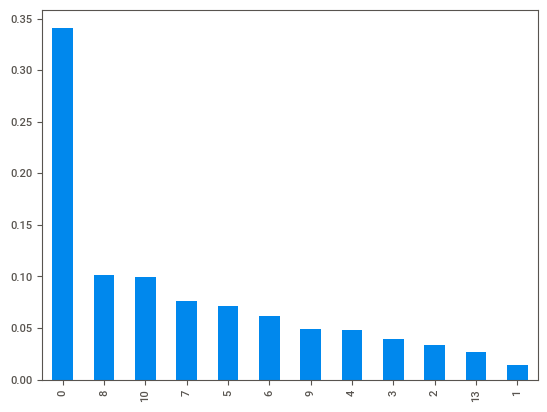

In [20]:
df_scaled['pain'].value_counts(normalize=True).sort_values(ascending=False)[:12].plot.bar()

In [21]:
df_scaled['pain'].value_counts(normalize=True).sort_values(ascending=False)[:12].sum() # Percentage of the whole column which is the 13 most common values

0.9608793164252932

Thus we can simply keep the 13 most common values in the pain column and replace the rest with 'unknown'

In [22]:
pain_values=list(df_scaled['pain'].value_counts(normalize=True).sort_values(ascending=False)[:12].keys())
df_scaled['pain'] = df_scaled['pain'].apply(lambda x: x if x in pain_values else 'unknown')
df_scaled['pain'].unique()

array(['7', '0', '10', '13', '5', '8', '1', '3', '6', '2', '4', 'unknown',
       '9'], dtype=object)

### Imputing missing values

All columns with null values with the exception of the chiefcomplaint column should be imputed. In addition, we should add a column isImputed to keep track of imputed rows and subsequently attenuate them in the loss function of our models

In [23]:
df_scaled.isna().sum()

temperature          17444
heartrate            10822
resprate             14233
o2sat                14512
sbp                  12084
dbp                  12927
pain                     0
acuity                   0
chiefcomplaint          17
gender                   0
race                     0
arrival_transport        0
disposition              0
arrival_hour             0
dtype: int64

We will use all numeric columns in our imputation but only select categorical columns seen to have a strong association with the numeric columns

In [24]:
IMPUTABLE_COLUMNS = NUMERIC_COLUMNS + ['acuity', 'gender', 'disposition', 'arrival_transport'] 
df_scaled['isImputed'] = [False for i in range(len(df_scaled))] # initially set all values to false
df_scaled.loc[df_scaled[IMPUTABLE_COLUMNS].isna().any(axis=1), 'isImputed'] = True # Set isImputed to true in any rows with a null value

Now we can utilize the iterative imputer to derive any misisng values using the known values in each given row.

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

We first need to one hot encode the categorical data so that they could be used by the imputer

In [26]:
CATEGORICAL_COLUMNS = [col for col in df_scaled.columns if col not in NUMERIC_COLUMNS and col != 'isImputed' and col != 'chiefcomplaint']

In [27]:
df_one_hot = pd.get_dummies(df_scaled[IMPUTABLE_COLUMNS], columns=[col for col in CATEGORICAL_COLUMNS if col in IMPUTABLE_COLUMNS])
df_one_hot

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity_1.0,acuity_2.0,acuity_3.0,acuity_4.0,...,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_EXPIRED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,disposition_TRANSFER
0,0.099097,0.070090,0.000988,0.010405,0.000463,0.000065,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.099706,0.056235,0.001129,0.010405,0.000695,0.000095,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0.100720,0.084760,0.001270,0.010298,0.000695,0.000086,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0.100213,0.070905,0.001270,0.010405,0.000761,0.000133,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0.100010,0.061940,0.001129,0.010513,0.000629,0.000076,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447706,0.099909,0.064385,0.001270,0.010727,0.001059,0.000151,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
447707,0.099300,0.073350,0.001129,0.010620,0.000973,0.000136,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
447708,0.099402,0.066830,0.001270,0.010727,0.000702,0.000113,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
447709,0.097880,0.090465,0.001270,0.010727,0.000721,0.000124,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Now we can impute all missing values and verify that only the chief complaint column contains missing values

In [28]:
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(df_one_hot[[col for col in df_one_hot.columns if col != 'chiefcomplaint' and col !='isImputed']]) # fit the imputer on the data and apply on the df
df_imputed = df_scaled.copy()
df_imputed[NUMERIC_COLUMNS] = imputed_values[:, :len(NUMERIC_COLUMNS)]
df_imputed.isna().sum()

temperature           0
heartrate             0
resprate              0
o2sat                 0
sbp                   0
dbp                   0
pain                  0
acuity                0
chiefcomplaint       17
gender                0
race                  0
arrival_transport     0
disposition           0
arrival_hour          0
isImputed             0
dtype: int64

We can also see that we imputed a bit over 6% of the rows in the dataset

In [29]:
df_imputed['isImputed'].value_counts()/len(df_imputed) * 100 
df_imputed.columns

Index(['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity', 'chiefcomplaint', 'gender', 'race', 'arrival_transport',
       'disposition', 'arrival_hour', 'isImputed'],
      dtype='object')

In [34]:
df_imputed.to_csv('./data/preprocessed_data.csv', index=False)

In [31]:
df_imputed.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,gender,race,arrival_transport,disposition,arrival_hour,isImputed
0,0.099097,0.070090,0.000988,0.010405,0.000463,0.000065,7,2.0,Hypotension,F,WHITE,AMBULANCE,HOME,16,False
1,0.099706,0.056235,0.001129,0.010405,0.000695,0.000095,0,3.0,"Abd pain, Abdominal distention",F,WHITE,AMBULANCE,ADMITTED,19,False
2,0.100720,0.084760,0.001270,0.010298,0.000695,0.000086,10,3.0,"n/v/d, Abd pain",F,WHITE,AMBULANCE,ADMITTED,20,False
3,0.100213,0.070905,0.001270,0.010405,0.000761,0.000133,10,3.0,Abdominal distention,F,WHITE,AMBULANCE,ADMITTED,15,False
4,0.100010,0.061940,0.001129,0.010513,0.000629,0.000076,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",F,WHITE,AMBULANCE,ADMITTED,5,False


### Chiefcomplaint EDA

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'textblob'

We will assign a new dataset for the text preprocessing graph output of the chiefcomplaint, it would not affect the prepocessed dataset.

In [ ]:
df_text = df_imputed
df_text.dropna(inplace=True)

##### Polarity with chiefcomplaint
We are going to take a look at some of the positive and negative chiefcomplaint, which indicates the acuity level. 

In [ ]:
# preprocess the data
def preprocess(chiefcomplaint):
    chiefcomplaint = chiefcomplaint.str.replace("(<br/>)", "")
    chiefcomplaint = chiefcomplaint.str.replace('(<a).*(>).*(</a>)', '')
    chiefcomplaint = chiefcomplaint.str.replace('(&amp)', '')
    chiefcomplaint = chiefcomplaint.str.replace('(&gt)', '')
    chiefcomplaint = chiefcomplaint.str.replace('(&lt)', '')
    chiefcomplaint = chiefcomplaint.str.replace('(\xa0)', ' ')  
    return chiefcomplaint

df_text['chiefcomplaint'] = preprocess(df_text['chiefcomplaint'])
df_text['Polarity'] = df_text['chiefcomplaint'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
print('Low Polarity chiefcomplaint:')
cl = df_text.loc[df_text.Polarity < 0.5, ['chiefcomplaint']].sample(5).values
for c in cl:
    print(c[0])
print(' ')
print('High Polarity chiefcomplaint:')
c2 = df_text.loc[df_text.Polarity > 0.5, ['chiefcomplaint']].sample(5).values
for c in c2:
    print(c[0])

Low Polarity chiefcomplaint:
Dyspnea on exertion
SI, SA
LE WEAKNESS
ABD PAIN
s/p Fall, Transfer
 
High Polarity chiefcomplaint:
"I DO NOT FEEL GOOD"
Transfer, ACUTE DISCITIS
R GREAT  TOE REDNESS
ACUTE CORONARY SYNDROME, Transfer
ACUTE ON CHRONIC HA


#### Unigrams, Bigrams and Trigrams with chiefcomplaint
We will extract N-Gram features. And these N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. 

In [ ]:
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)
        
    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df

stop_words = None
n = 20
unigrams = get_top_ngrams(df_text['chiefcomplaint'], (1, 1), stop_words, n)
bigrams = get_top_ngrams(df_text['chiefcomplaint'], (2, 2), stop_words, n)
trigrams = get_top_ngrams(df_text['chiefcomplaint'], (3, 3), stop_words, n)

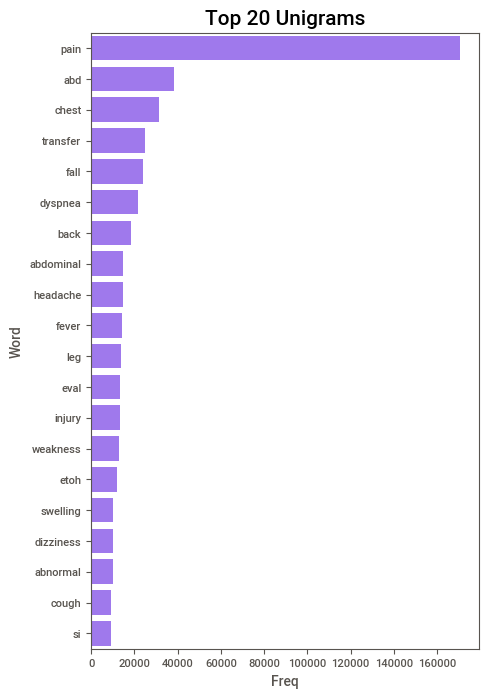

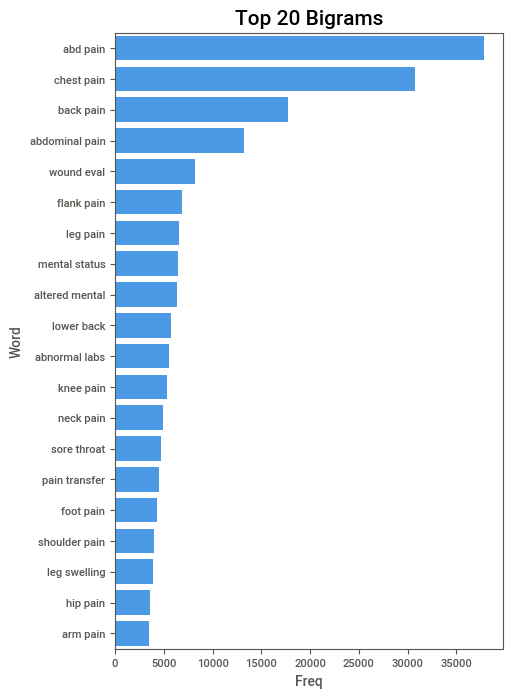

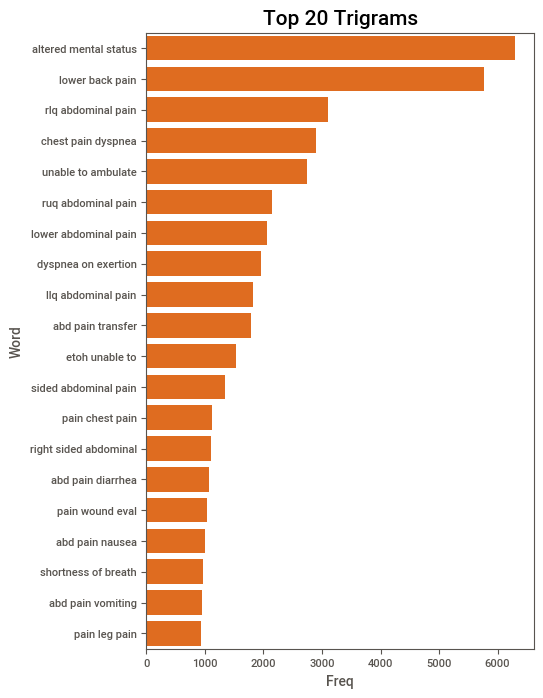

In [ ]:
colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']

plt.figure(figsize=(5, 8))
sns.barplot(x='Freq', y='Word', color=colors[0], data=unigrams)
plt.title('Top 20 Unigrams', size=15)
plt.show()

plt.figure(figsize=(5, 8))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bigrams)
plt.title('Top 20 Bigrams', size=15)
plt.show()

plt.figure(figsize=(5, 8))
sns.barplot(x='Freq', y='Word', color=colors[3], data=trigrams)
plt.title('Top 20 Trigrams', size=15)
plt.show()

We will plot the wordcloud for the chiefcomplaint.

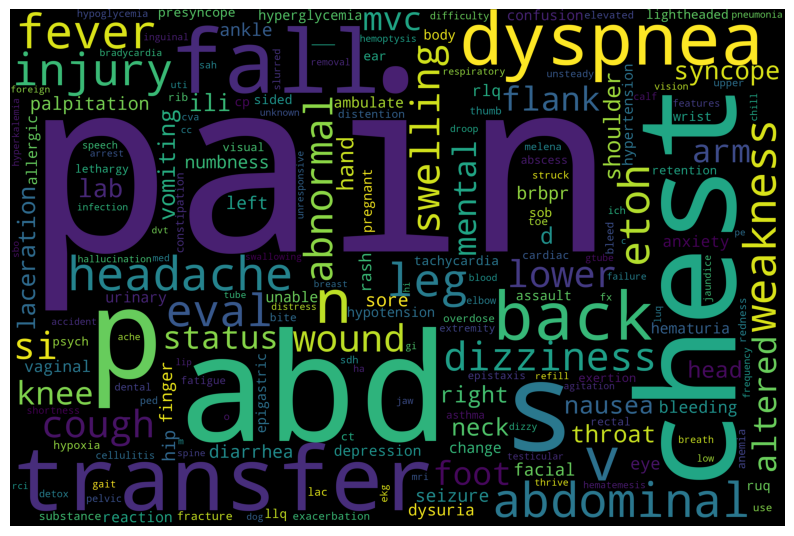

In [ ]:
tokenized = list()
for complaint in triage['chiefcomplaint']:
    if complaint == complaint:
        for word in complaint.split(' '):
            if(len(word) <= 1): continue
            tokenized.append(word.lower().replace(',', '').replace('.', '').replace('(', '').replace(')', '').rstrip())
            
cloud = WordCloud(width = 3000, height = 2000,
                       collocations=False).generate(" ".join(tokenized))

def cloud_plot(wordcloud): 
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(wordcloud) 
cloud_plot(cloud)

The chiefcomplaint column requires natural language processing techniques to gain insights into its composition. To better understand the relationship between the words in the triage notes we can train our own word2vec model and then visualize the embeddings it generates in a lowe dimensional space.

gensim simple preprocess can be used to tokenize the notes.

In [ ]:
from gensim.models import Word2Vec
from gensim import utils
tokenizer = utils.simple_preprocess

In [ ]:
tokenized_notes = df['chiefcomplaint'].dropna().apply((lambda x: tokenizer(x.replace('+', 'positive').replace('-', 'negative')))) # replace symbols with their word
tokenized_notes

0                                        [hypotension]
1                   [abd, pain, abdominal, distention]
2                                          [abd, pain]
3                              [abdominal, distention]
4         [abdominal, distention, abd, pain, lethagic]
                              ...                     
447707                                 [abnormal, mri]
447708                        [abd, pain, wound, eval]
447709                        [abd, pain, wound, eval]
447710       [altered, mental, status, substance, use]
447711                                   [head, bleed]
Name: chiefcomplaint, Length: 447689, dtype: object

We can also derive the entire size of the vocabulary by flattening the list of tokens.

In [ ]:
import itertools
vocab = list(set(itertools.chain.from_iterable(tokenized_notes))) # flatten the vocabulary
len(vocab)

5326

Now that we have the tokenized and preprocessed the notes a word2vec model can be trained.

In [ ]:
from time import time
cores=16
model = Word2Vec(min_count=1,
                     window=2,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
t = time()

model.build_vocab(tokenized_notes)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


t = time()

model.train(tokenized_notes, total_examples=model.corpus_count, epochs=100, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins
Time to train the model: 1.0 mins


In [ ]:
import umap
import umap.plot
import bokeh.plotting as bp

EMBEDDINGS = model.wv[vocab]
umap_model = umap.UMAP(n_neighbors=5)

# Fit the data using the word embedding
mapper = umap_model.fit(EMBEDDINGS)
hover_data = pd.DataFrame({'index':np.arange(len(vocab)),
                           'label':vocab})

UMAP and bokeh can be used to plot the embeddings

In [ ]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=vocab, hover_data=hover_data, point_size=6)
umap.plot.show(p)

Loading BokehJS ...